## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)

## Objective

To build a model capable of learning an artist's style.

Dataset used: https://www.kaggle.com/datasets/vbookshelf/art-by-ai-neural-style-transfer/data

## Download the dataset

First create a kaggle API token and upload the generated JSON file.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vbookshelf/art-by-ai-neural-style-transfer

100% 463M/463M [00:25<00:00, 21.5MB/s]
100% 463M/463M [00:25<00:00, 19.0MB/s]


In [ ]:
!unzip -qq art-by-ai-neural-style-transfer.zip

In [3]:
import os
input_dir = "Data\\source"
input_img_paths = sorted(
 [os.path.join(input_dir, fname)
 for fname in os.listdir(input_dir)
 if fname.endswith(".jpg")])
len(input_img_paths)

10200

In [4]:
target_dir = "Data\\target"
target_img_paths = sorted(
 [os.path.join(target_dir, fname)
 for fname in os.listdir(target_dir)
 if fname.endswith(".jpg")])
len(target_img_paths)

10200

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2
import PIL

from tensorflow.keras import Model

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram_matrix/i_j 

In [23]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
    vgg.load_weights('C:\\Users\\Uvanesh\\Downloads\\vgg19_weights_tf_dim_ordering_tf_kernels.h5')
    vgg.trainable = False
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_output = vgg.get_layer(content_layers[0]).output 
    style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    gram_style_output = [gram_matrix(output_) for output_ in style_output]

    model = Model([vgg.input], [content_output, gram_style_output])
    return model

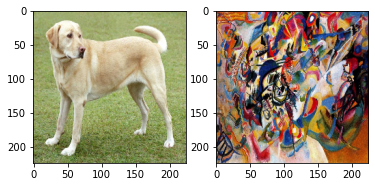

In [25]:
content_image = cv2.resize(cv2.imread('C:\\Users\\Uvanesh\\Downloads\\YellowLabradorLooking_new.jpg'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('C:\\Users\\Uvanesh\\Downloads\\Vassily_Kandinsky,_1913_-_Composition_7.jpg'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
    style_weight = 1e-2
    content_weight = 1e-1
    content_loss = tf.reduce_mean((content_outputs - content_target)**2)
    style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
    total_loss = content_weight*content_loss + style_weight*style_loss
    return total_loss

In [27]:
opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)


In [29]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [30]:
def train_step(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image*255)
        loss = loss_object(output[1], output[0], style_target, content_target)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 ==0:
        
        tf.print(f"Loss = {loss}")

In [33]:
EPOCHS = 100
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train_step(image, i)

Loss = 15748033536.0


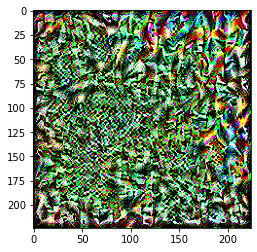

In [34]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()

## Loading the Dataset

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from keras.utils import normalize
import matplotlib.pyplot as plt

In [32]:
input_dataset=[]
for i,image_path in enumerate(input_img_paths):
    if i == 4000:
        break
    image=Image.open(image_path)
  # image=Image.fromarray(image)
    image=image.resize((256,256))
    input_dataset.append(np.array(image))

In [33]:
print(len(input_dataset))
print(input_dataset[0].shape)

4000
(256, 256, 3)


In [35]:
target_dataset=[]
for i,image_path in enumerate(target_img_paths):
    if i == 4000:
        break
    image=Image.open(image_path)
    image=image.resize((256,256))
    target_dataset.append(np.array(image))

In [36]:
print(len(target_dataset))
print(target_dataset[0].shape)

4000
(256, 256, 3)


In [38]:
source_data = np.array(input_dataset)
target_data = np.array(target_dataset)

In [39]:
print(source_data.shape)
print(target_data.shape)

(4000, 256, 256, 3)
(4000, 256, 256, 3)


In [41]:
source_data = source_data / 255
target_data = target_data / 255

In [42]:
source_data

array([[[[1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         ...,
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549]],

        [[1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         ...,
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549]],

        [[1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         [1.        , 0.97647059, 0.91372549],
         ...,
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549],
         [0.98431373, 0.97254902, 0.91372549]],

        ...,

        [[0.49803922, 0.47058824, 0.36470588],
         [0.51372549, 0.48627451, 0.38039216]

In [43]:
del input_dataset
del target_dataset

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(source_data,target_data,test_size=0.2,random_state=2)

In [17]:
import tensorflow as tf

In [18]:
height=256
width=256
channels=3

In [81]:
inputs=tf.keras.layers.Input((height,width,channels))

c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)


c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.1)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.1)(c4)
c4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same', name='c4_2')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.1)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

#upsampling
v6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
v6=tf.keras.layers.concatenate([v6,c4])
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(v6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

v7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
v7=tf.keras.layers.concatenate([v7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(v7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

v8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
v8=tf.keras.layers.concatenate([v8,c2])
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(v8)
c8=tf.keras.layers.Dropout(0.2)(c8)
c8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

v9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
v9=tf.keras.layers.concatenate([v9,c1],axis=3)
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(v9)
c9=tf.keras.layers.Dropout(0.2)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs=tf.keras.layers.Conv2DTranspose(channels,(2,2),padding='same')(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])

In [82]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_120 (Conv2D)            (None, 256, 256, 16  448         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_63 (Dropout)           (None, 256, 256, 16  0           ['conv2d_120[0][0]']             
                                )                                                           

In [65]:
from tensorflow import keras
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (0, 3, 1, 2))
    features = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 256 * 256
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [83]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [49]:
del source_data
del target_data

In [84]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5',verbose=1,save_best_only=True)
early=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
callback=[checkpointer,early]
results=model.fit(x_train,y_train,validation_split=0.2,batch_size=8,epochs=50,callbacks=callback)

Epoch 1/50
320/320 [==============================] - ETA: 0s - loss: 0.0269
Epoch 1: val_loss improved from inf to 0.01891, saving model to model_for_nuclei.h5
320/320 [==============================] - 24s 74ms/step - loss: 0.0269 - val_loss: 0.0189
Epoch 2/50
320/320 [==============================] - ETA: 0s - loss: 0.0190
Epoch 2: val_loss improved from 0.01891 to 0.01796, saving model to model_for_nuclei.h5
320/320 [==============================] - 23s 71ms/step - loss: 0.0190 - val_loss: 0.0180
Epoch 3/50
320/320 [==============================] - ETA: 0s - loss: 0.0178
Epoch 3: val_loss improved from 0.01796 to 0.01682, saving model to model_for_nuclei.h5
320/320 [==============================] - 23s 72ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 4/50
320/320 [==============================] - ETA: 0s - loss: 0.0170
Epoch 4: val_loss improved from 0.01682 to 0.01589, saving model to model_for_nuclei.h5
320/320 [==============================] - 23s 72ms/step - loss: 0.0170

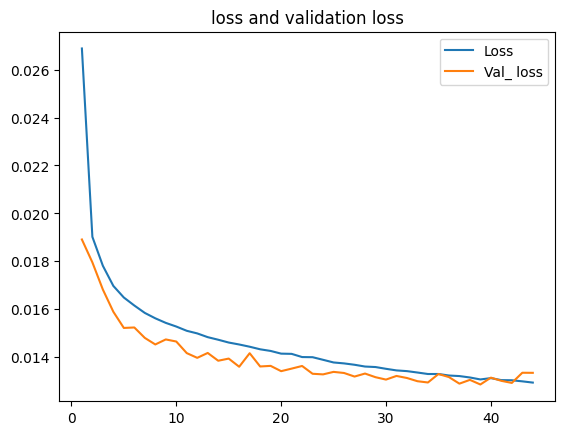

In [85]:
loss=results.history['loss']
val_loss=results.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,label='Loss')
plt.plot(epochs,val_loss,label='Val_ loss')
plt.title('loss and validation loss')
plt.legend()
plt.show()

In [86]:
acc=model.evaluate(x_test,y_test)
print(acc)

25/25 [==============================] - 2s 79ms/step - loss: 0.0135
0.013491243124008179


In [52]:
import random

In [87]:
test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_img_input)[0] * 255).astype(np.uint8)

1/1 [==============================] - 0s 164ms/step


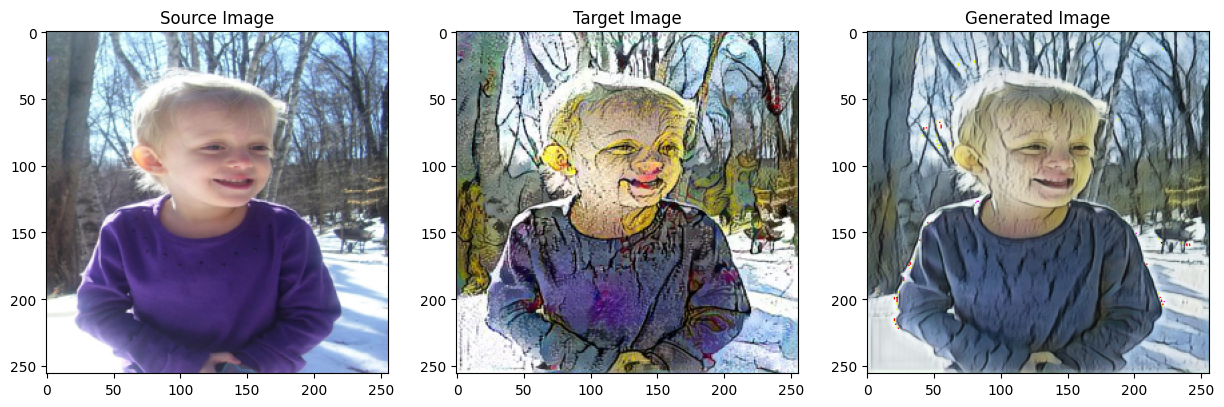

In [88]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Source Image')
plt.imshow((test_img * 255).astype(np.uint8))
plt.subplot(132)
plt.title('Target Image')
plt.imshow((ground_truth * 255).astype(np.uint8))
plt.subplot(133)
plt.title('Generated Image')
plt.imshow(prediction)
plt.show()

In [80]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [90]:
test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_img_input)[0] * 255).astype(np.uint8)

1/1 [==============================] - 0s 15ms/step


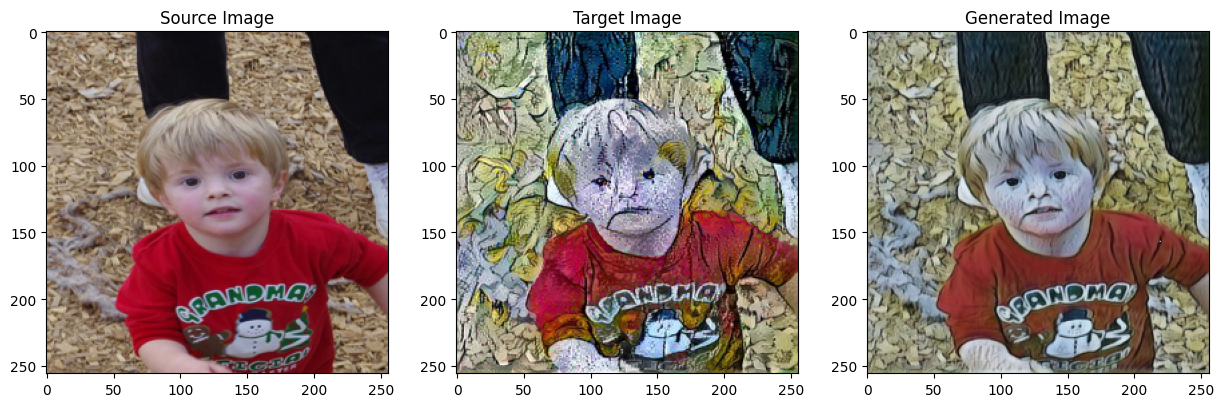

1/1 [==============================] - 0s 15ms/step


In [91]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Source Image')
plt.imshow((test_img * 255).astype(np.uint8))
plt.subplot(132)
plt.title('Target Image')
plt.imshow((ground_truth * 255).astype(np.uint8))
plt.subplot(133)
plt.title('Generated Image')
plt.imshow(prediction)
plt.show()
test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_img_input)[0] * 255).astype(np.uint8)

In [92]:
test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_img_input)[0] * 255).astype(np.uint8)

1/1 [==============================] - 0s 18ms/step


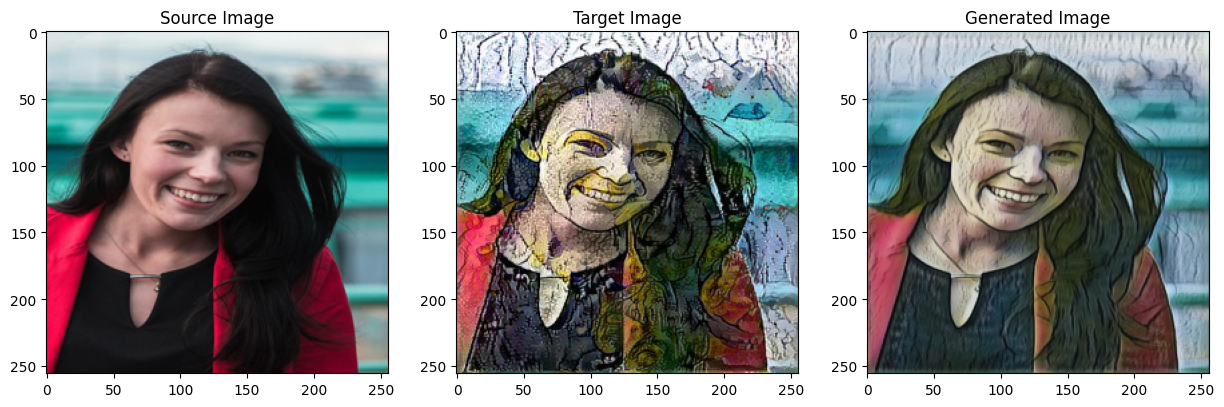

1/1 [==============================] - 0s 16ms/step


In [93]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Source Image')
plt.imshow((test_img * 255).astype(np.uint8))
plt.subplot(132)
plt.title('Target Image')
plt.imshow((ground_truth * 255).astype(np.uint8))
plt.subplot(133)
plt.title('Generated Image')
plt.imshow(prediction)
plt.show()
test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img,0)
prediction=(model.predict(test_img_input)[0] * 255).astype(np.uint8)